# Showcasing the qick-qcodes software 

## Helper functions

In [2]:
%matplotlib widget

%load_ext autoreload
%autoreload 1
%aimport metainstruments.ZCUStation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initializing the station and the experiment

In [4]:
import qcodes as qc
from qcodes.instrument import Instrument, ManualParameter
from qcodes.station import Station

from metainstruments.ZCUStation import ZCU216Station
from metainstruments.ZCUMetainstrument import ZCU216Metainstrument
from measurements.Protocols import Protocol
from measurements.T1Protocol import T1Protocol
from measurements.PulseProbeSpectroscopyProtocol import PulseProbeSpectroscopyProtocol
from measurements.NDSweepProtocol import NDSweepProtocol
from qick import *

import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Initializing the station and the database
qc.initialise_or_create_database_at("../experiment-data/BF4-CD2.db")
station = ZCU216Station()

QICK library version mismatch: 0.2.211 remote (the board), 0.2.224 local (the PC)
                        This may cause errors, usually KeyError in QickConfig initialization.
                        If this happens, you must bring your versions in sync.


Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_e8ac0003070944599fd9b788ae91b13f@10.0.100.16:39317


In [6]:
#Initializing the experiment
experiment = qc.load_or_create_experiment(
                experiment_name="BF4-CD2",
                sample_name="Cavity-20")

## Adding QICK Channels

In [5]:
# The following command can be used to configure to see what qick channel corresponds to what physical port
print(station.troubleshoot())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.211
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

In [7]:
#At the time of writing, we have connected DACs 2_231 and 0_231 to the adc's and oscilloscopes, these have  
#qick channels 6 and 4. The physically connected ADC channel is 0_226. Thus, our configuration will be:
station.add_DAC_channel(name="Qubit", channel=6)
station.add_DAC_channel(name="Readout", channel=0)
station.add_ADC_channel(name="ADC", channel=0)

## VNA program

The vna program, handled by the NDSweepProtocol, sends a pulse from the 'probe' dac channel and triggers the 'adc' adc channel. The attributes of the sent pulse are contained in the parameters of the 'probe' dac channel, and the readout settings are contained in the protocol parameters.

In [8]:
# Initialization of the protocol
vnaprotocol = station.add_protocol(NDSweepProtocol(name='vna'))

In [9]:
station.vna.print_readable_snapshot()

vna:
	parameter      value
--------------------------------------------------------------------------------
adc_trig_offset :	100 (Clock ticks)
readout_length  :	5 (us)
relax_delay     :	0.1 (us)
reps            :	400 


In [10]:
station.Qubit.print_readable_snapshot()

Qubit:
	parameter   value
--------------------------------------------------------------------------------
channel      :	6 
nqz          :	1 
pulse_freq   :	500 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)


In [11]:
station.ADC.print_readable_snapshot()

ADC:
	parameter value
--------------------------------------------------------------------------------
channel :	0 


In [12]:
station.Qubit.pulse_gain(10000)
station.Qubit.pulse_length(1)
station.Qubit.pulse_freq(4800)
station.Qubit.nqz(2)

station.Qubit.print_readable_snapshot()

Qubit:
	parameter   value
--------------------------------------------------------------------------------
channel      :	6 
nqz          :	2 
pulse_freq   :	4800 (MHz)
pulse_gain   :	10000 (DAC units)
pulse_length :	1 (us)
pulse_phase  :	0 (deg)


In [13]:
station.vna.reps(500)
station.vna.relax_delay(2)
station.vna.readout_length(10)
station.vna.adc_trig_offset(122)

station.vna.print_readable_snapshot()

vna:
	parameter      value
--------------------------------------------------------------------------------
adc_trig_offset :	122 (Clock ticks)
readout_length  :	10 (us)
relax_delay     :	2 (us)
reps            :	500 


## Resonator 1 power and frequency sweep 

In [71]:
vna_run_id = station.measure_iq(params_and_values = {  station.Qubit.pulse_freq: [5545, 5560, 100], station.Qubit.pulse_gain: [10, 10000, 100]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Qubit},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 9. 


  0%|          | 0/100 [00:00<?, ?it/s]

The program has run succesfully, and the measure_iq method returns a run_id, with wich you can access the database:

## Bare resonator frequency sweep

In [13]:
station.Qubit.pulse_gain(40000)
station.vna.reps(1000)

In [93]:
bare_resonator_rid = station.measure_iq(params_and_values = {  station.Qubit.pulse_freq: [5545, 5560, 1000]},#, station.Qubit.pulse_gain: [10, 10000, 100]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Qubit},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 11. 


  0%|          | 0/1000 [00:00<?, ?it/s]

# Dressed resonator frequency sweep

In [14]:
station.Qubit.pulse_gain(1)
station.Qubit.pulse_length(30)

station.vna.relax_delay(3)
station.vna.reps(5000)
station.vna.readout_length(30)

In [113]:
dressed_resonator_rid = station.measure_iq(params_and_values = {  station.Qubit.pulse_freq: [5545, 5560, 2000]},#, station.Qubit.pulse_gain: [10, 10000, 100]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Qubit},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 16. 


  0%|          | 0/2000 [00:00<?, ?it/s]

# Finding the punchout gain

In [14]:
station.Qubit.pulse_length(30)

station.vna.adc_trig_offset(122)
station.vna.relax_delay(3)
station.vna.reps(100)
station.vna.readout_length(30)

In [123]:
vna_run_id = station.measure_iq(params_and_values = {  station.Qubit.pulse_freq: [5550, 5556, 500], station.Qubit.pulse_gain: [1, 4000, 500]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Qubit},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 18. 


  0%|          | 0/500 [00:00<?, ?it/s]

# Two tone spectroscopy

In [7]:
ppsprotocol = station.add_protocol(PulseProbeSpectroscopyProtocol(name='pps'))

In [40]:
station.pps.adc_trig_offset(122)
station.pps.relax_delay(800)
station.pps.reps(1000)


station.pps.print_readable_snapshot()

pps:
	parameter          value
--------------------------------------------------------------------------------
adc_trig_offset     :	122 (Clock ticks)
readout_pulse_delay :	0.05 (us)
relax_delay         :	800 (us)
reps                :	1000 


In [26]:
station.Readout.channel(0)
station.Readout.pulse_freq(5553.3)
station.Readout.pulse_gain(5000)
station.Readout.pulse_length(10)
station.Readout.nqz(2)


station.Readout.print_readable_snapshot()

Readout:
	parameter   value
--------------------------------------------------------------------------------
channel      :	0 
nqz          :	2 
pulse_freq   :	5553.3 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)


In [27]:
station.Qubit.channel(4)
station.Qubit.pulse_gain(40000)
station.Qubit.pulse_length(150)
station.Qubit.pulse_freq(2694.4)
station.Qubit.nqz(1)


station.Qubit.print_readable_snapshot()

Qubit:
	parameter   value
--------------------------------------------------------------------------------
channel      :	4 
nqz          :	1 
pulse_freq   :	2694.4 (MHz)
pulse_gain   :	40000 (DAC units)
pulse_length :	150 (us)
pulse_phase  :	0 (deg)


In [42]:
station.measure_iq(params_and_values = {  station.pps.readout_pulse_delay : [0.1, 100, 100]}, 
                         protocol = station.pps, 
                         dac_channels = {'qubit' : station.Qubit,'readout': station.Readout},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 87. 


  0%|          | 0/100 [00:00<?, ?it/s]

87

In [9]:
pi_len=0.829

In [25]:
try:
    station.remove_protocol(station.t1)
except AttributeError:
    pass
station.add_protocol(T1Protocol('t1'))

In [26]:
station.t1.adc_trig_offset(122)
station.t1.relax_delay(900)


station.t1.print_readable_snapshot()

station.Qubit.channel(4)
station.Qubit.pulse_gain(40000)

station.Qubit.pulse_length(pi_len)
station.Qubit.pulse_freq(2694.4)
station.Qubit.nqz(1)


station.Qubit.print_readable_snapshot()

station.Readout.channel(0)
station.Readout.pulse_freq(5553.3)
station.Readout.pulse_gain(5000)
station.Readout.pulse_length(10)
station.Readout.nqz(2)


station.Readout.print_readable_snapshot()

t1:
	parameter      value
--------------------------------------------------------------------------------
adc_trig_offset :	122 (Clock ticks)
relax_delay     :	900 (us)
reps            :	400 
variable_delay  :	5 (us)
Qubit:
	parameter   value
--------------------------------------------------------------------------------
channel      :	4 
nqz          :	1 
pulse_freq   :	2694.4 (MHz)
pulse_gain   :	40000 (DAC units)
pulse_length :	0.829 (us)
pulse_phase  :	0 (deg)
Readout:
	parameter   value
--------------------------------------------------------------------------------
channel      :	0 
nqz          :	2 
pulse_freq   :	5553.3 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)


In [33]:
station.t1.reps(200)

pps_run_id = station.measure_iq(params_and_values = {  station.t1.variable_delay: [1, 1000, 10]}, 
                         protocol = station.t1, 
                         dac_channels = {'qubit' : station.Qubit, 'readout': station.Readout},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 99. 


  0%|          | 0/2000 [00:00<?, ?it/s]

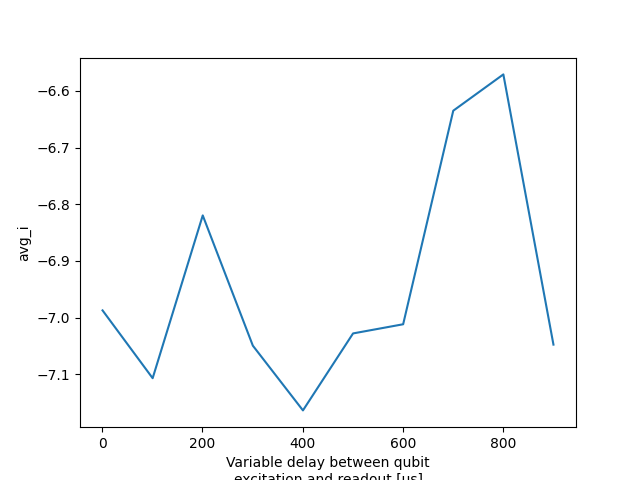

In [34]:
qc.load_by_id(99).to_xarray_dataset()["avg_i"].plot(ax=plt.figure().gca())

In [24]:
pi_lenght = 0.760